<a href="https://colab.research.google.com/github/ayoraheem0000/Data/blob/main/Untitled14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2025-06-23 19:27:17.415 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-23 19:27:17.424 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-23 19:27:18.035 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-06-23 19:27:18.039 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-23 19:27:18.042 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-23 19:27:18.046 No runtime found, using MemoryCacheStorageManager
2025-06-23 19:27:18.051 No runtime found, using MemoryCacheStorageManager
2025-06-23 19:27:18.055 Thread 'MainThread': missing ScriptRunContext! This warning ca

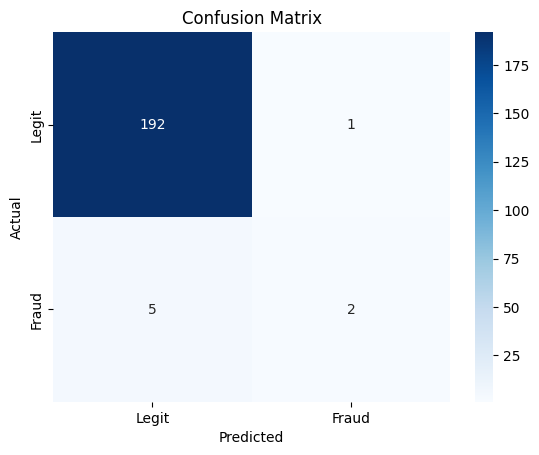

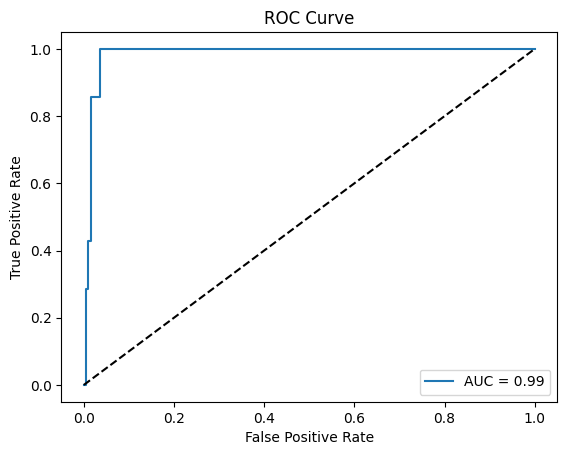

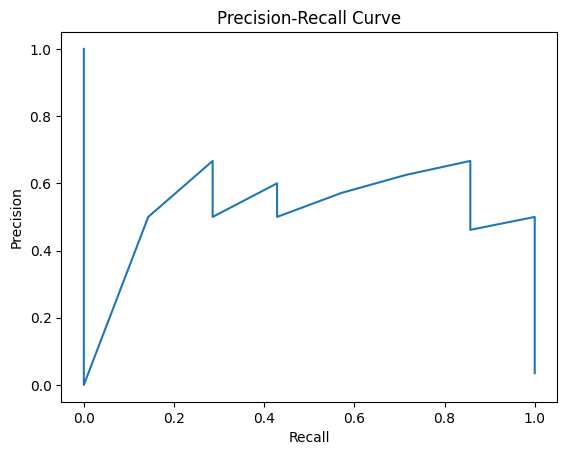

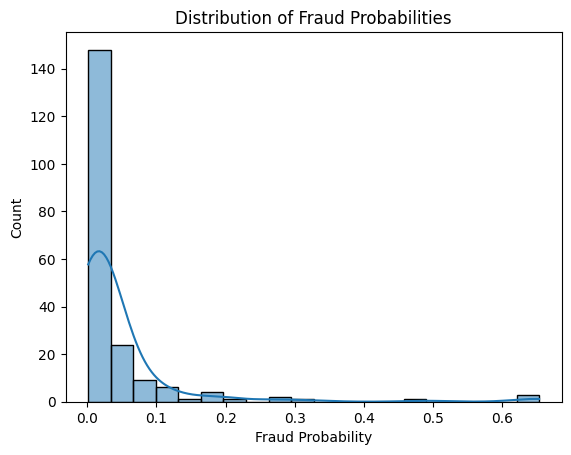

In [2]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import io
import shap







from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
)

# Constants
FEATURE_COLS = ['TransactionAmount', 'TransactionTime', 'UserBehaviorScore']
MODEL_FILE = "logistic_model.pkl"

# Authentication

# Streamlit config
st.set_page_config(page_title="Fraud Detection App", layout="wide")
st.title("\U0001F4B3 Fraud Detection Web App")

@st.cache_data
def generate_data(n_samples=1000):
    np.random.seed(42)
    transaction_amount = np.random.exponential(scale=100, size=n_samples)
    transaction_time = np.random.randint(0, 24, size=n_samples)
    user_behavior_score = np.random.normal(loc=0.5, scale=0.15, size=n_samples)
    fraud = ((transaction_amount > 180) & (user_behavior_score < 0.4)).astype(int)
    return pd.DataFrame({
        'TransactionAmount': transaction_amount,
        'TransactionTime': transaction_time,
        'UserBehaviorScore': user_behavior_score,
        'IsFraud': fraud
    })

def train_selected_model(data, choice):
    X = data[FEATURE_COLS]
    y = data['IsFraud']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    if choice == "Random Forest":
        model = RandomForestClassifier()
    else:
        model = LogisticRegression()
    model.fit(X_train, y_train)
    joblib.dump(model, MODEL_FILE)
    return model, X_test, y_test

def evaluate_model(y_true, y_pred, y_prob):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_prob)
    }

@st.cache_resource
def get_explainer(model, X_sample):
    return shap.Explainer(model, X_sample)

# Data and model selection
df = generate_data()
model_choice = st.sidebar.selectbox("Choose Model", ["Logistic Regression", "Random Forest"])
model, X_test, y_test = train_selected_model(df, model_choice)

# Retrain button
if st.sidebar.button("\U0001F501 Retrain Model"):
    with st.spinner("Retraining model..."):
        model, X_test, y_test = train_selected_model(df, model_choice)
        st.sidebar.success("Model retrained successfully!")

# Sidebar - single prediction
st.sidebar.header("\U0001F50D Single Transaction Prediction")
amount = st.sidebar.number_input("Transaction Amount", min_value=0.0, value=100.0)
time = st.sidebar.slider("Transaction Time (Hour)", 0, 23, 12)
score = st.sidebar.slider("User Behavior Score", 0.0, 1.0, 0.5)

if st.sidebar.button("Predict Fraud"):
    input_data = pd.DataFrame([[amount, time, score]], columns=FEATURE_COLS)
    prediction = model.predict(input_data)[0]
    probability = model.predict_proba(input_data)[0][1]
    st.sidebar.success(f"Prediction: {'Fraud' if prediction else 'Legit'} (Probability: {probability:.2f})")

    explainer = get_explainer(model, df[FEATURE_COLS].sample(100))
    shap_values = explainer(input_data)
    st.sidebar.subheader("\U0001F4CC SHAP Explanation")
    fig_shap = shap.plots.waterfall(shap_values[0], show=False)
    st.sidebar.pyplot(fig_shap.figure)

# Tabs
tab1, tab2, tab3 = st.tabs(["\U0001F4C1 Batch Prediction", "\U0001F4CA Metrics", "\U0001F4C8 Visualizations"])

with tab1:
    st.header("\U0001F4C1 Upload CSV for Batch Prediction")
    uploaded_file = st.file_uploader("Upload CSV", type=["csv"])
    if uploaded_file:
        try:
            batch_data = pd.read_csv(uploaded_file)
            if all(col in batch_data.columns for col in FEATURE_COLS):
                preds = model.predict(batch_data[FEATURE_COLS])
                probs = model.predict_proba(batch_data[FEATURE_COLS])[:, 1]
                batch_data['IsFraudPrediction'] = preds
                batch_data['FraudProbability'] = probs
                st.dataframe(batch_data)

                selected_cols = st.multiselect("Select columns to download", batch_data.columns.tolist(), default=batch_data.columns.tolist())
                if selected_cols:
                    csv_buffer = io.StringIO()
                    batch_data[selected_cols].to_csv(csv_buffer, index=False)
                    st.download_button("\U0001F4E5 Download Selected Columns", csv_buffer.getvalue(), file_name="filtered_fraud_predictions.csv", mime="text/csv")
            else:
                st.error(f"CSV must contain columns: {FEATURE_COLS}")
        except Exception as e:
            st.error(f"Error reading file: {e}")

    if st.button("\U0001F3B2 Simulate Random Transaction"):
        rand_amount = np.random.exponential(100)
        rand_time = np.random.randint(0, 24)
        rand_score = np.random.normal(0.5, 0.15)
        sim_input = pd.DataFrame([[rand_amount, rand_time, rand_score]], columns=FEATURE_COLS)
        sim_pred = model.predict(sim_input)[0]
        sim_prob = model.predict_proba(sim_input)[0][1]
        st.info(f"Random Transaction: Amount={rand_amount:.2f}, Time={rand_time}, Score={rand_score:.2f}")
        st.success(f"Prediction: {'Fraud' if sim_pred else 'Legit'} (Probability: {sim_prob:.2f})")

with tab2:
    st.header("\U0001F4CA Model Evaluation Metrics")
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    metrics = evaluate_model(y_test, y_pred, y_prob)
    for k, v in metrics.items():
        st.write(f"{k}: {v:.2f}")

    st.subheader("\U0001F4CC Feature Importance (Logistic Coefficients or RF Importances)")
    if model_choice == "Random Forest":
        importance_df = pd.DataFrame({
            "Feature": FEATURE_COLS,
            "Importance": model.feature_importances_
        }).sort_values(by="Importance", ascending=False)
    else:
        importance_df = pd.DataFrame({
            "Feature": FEATURE_COLS,
            "Coefficient": model.coef_[0]
        }).sort_values(by="Coefficient", key=abs, ascending=False)
    st.dataframe(importance_df)

with tab3:
    st.header("\U0001F4C8 Visualizations")

    cm = confusion_matrix(y_test, y_pred)
    fig_cm, ax_cm = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'], ax=ax_cm)
    ax_cm.set_xlabel("Predicted")
    ax_cm.set_ylabel("Actual")
    ax_cm.set_title("Confusion Matrix")
    st.pyplot(fig_cm)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    fig_roc, ax_roc = plt.subplots()
    ax_roc.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
    ax_roc.plot([0, 1], [0, 1], 'k--')
    ax_roc.set_xlabel("False Positive Rate")
    ax_roc.set_ylabel("True Positive Rate")
    ax_roc.set_title("ROC Curve")
    ax_roc.legend()
    st.pyplot(fig_roc)

    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    fig_pr, ax_pr = plt.subplots()
    ax_pr.plot(recall, precision)
    ax_pr.set_xlabel("Recall")
    ax_pr.set_ylabel("Precision")
    ax_pr.set_title("Precision-Recall Curve")
    st.pyplot(fig_pr)

    st.subheader("\U0001F4C9 Fraud Probability Distribution")
    fig_dist, ax_dist = plt.subplots()
    sns.histplot(y_prob, bins=20, kde=True, ax=ax_dist)
    ax_dist.set_title("Distribution of Fraud Probabilities")
    ax_dist.set_xlabel("Fraud Probability")
    st.pyplot(fig_dist)
